In [442]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# loading data

In [443]:
salary_data=pd.read_csv('employee_salary.csv')
salary_data.head()

,Name,Team,Number,Position,Age,DOJ,Weight,College,Salary
0,Avery Bradley,Boston Celtics,0,PG,25,06-Feb,180,Texas,7730337.0
1,Jae Crowder,Boston Celtics,99,SF,25,06-Jun,235,Marquette,6796117.0
2,John Holland,Boston Celtics,30,SG,27,06-May,205,Boston University,NaN
3,R.J. Hunter,Boston Celtics,28,SG,22,06-May,185,Georgia State,1148640.0
4,Jonas Jerebko,Boston Celtics,8,PF,29,06-Oct,231,NaN,5000000.0


# Analysing data

In [444]:
salary_data.shape

(457, 9)

In [445]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      457 non-null    object 
 1   Team      457 non-null    object 
 2   Number    457 non-null    int64  
 3   Position  457 non-null    object 
 4   Age       457 non-null    int64  
 5   DOJ       457 non-null    object 
 6   Weight    457 non-null    int64  
 7   College   373 non-null    object 
 8   Salary    446 non-null    float64
dtypes: float64(1), int64(3), object(5)
memory usage: 32.3+ KB


In [446]:
salary_data.isna().sum()

Name         0
Team         0
Number       0
Position     0
Age          0
DOJ          0
Weight       0
College     84
Salary      11
dtype: int64

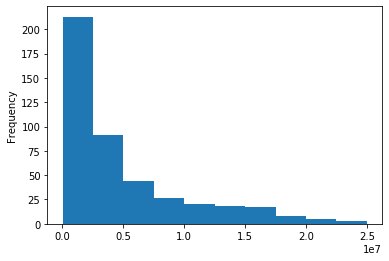

In [496]:
salary_data['Salary'].plot(kind='hist',bins=10)

# Data preprocessing

Fixing NaN values

In [447]:
salary_data.drop(['Name','DOJ','College'],axis=1,inplace=True)

In [448]:
#salary_data['College'].fillna('Kentucky',inplace=True)
#salary_data['Salary'].replace(np.nan,salary_data['Salary'].mean(),inplace=True)
salary_data.dropna(axis=0,subset=['Salary'],inplace=True)

In [449]:
salary_data.isna().sum()

Team        0
Number      0
Position    0
Age         0
Weight      0
Salary      0
dtype: int64

In [450]:
salary_data.shape

(446, 6)

In [451]:
from sklearn.preprocessing import LabelEncoder
for i in ['Team','Position']:
    salary_data[i]=LabelEncoder().fit_transform(salary_data[i])
salary_data.head()

,Team,Number,Position,Age,Weight,Salary
0,1,0,2,25,180,7730337.0
1,1,99,3,25,235,6796117.0
3,1,28,4,22,185,1148640.0
4,1,8,1,29,231,5000000.0
5,1,90,1,29,240,12000000.0


Removing Outliers

In [452]:
import scipy
from scipy.stats import zscore
z=abs(zscore(salary_data))
salary_no_outlier=salary_data[(z<3).all(axis=1)]

In [467]:
salary_no_outlier.head()

,Team,Number,Position,Age,Weight,Salary
0,1,0,2,25,180,7730337.0
3,1,28,4,22,185,1148640.0
4,1,8,1,29,231,5000000.0
6,1,55,1,21,235,1170960.0
7,1,41,0,25,238,2165160.0


In [469]:
salary_no_outlier.shape

(432, 6)

In [481]:
import sklearn
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [479]:
from sklearn.preprocessing import StandardScaler
salary=salary_no_outlier
columns=['Team','Number','Position','Age','Weight','Salary']
#salary_data[columns]=StandardScaler().fit_transform(salary_data[columns])
salary[columns]=StandardScaler().fit_transform(salary[columns])

In [480]:
salary.head()

,Team,Number,Position,Age,Weight,Salary
0,-1.570939,-1.234365,-0.062320,-0.420782,-1.593415,0.652271
3,-1.570939,0.842541,1.354637,-1.105014,-1.400013,-0.712330
4,-1.570939,-0.640963,-0.770798,0.491528,0.379282,0.086183
6,-1.570939,2.845273,-0.770798,-1.333091,0.534003,-0.707702
7,-1.570939,1.806820,-1.479277,-0.420782,0.650044,-0.501572


In [453]:
# preparing a function to find best random state for accuracy
def regression(dataset,test_size,model):
    max=0
    ind=0
    x=dataset.iloc[:,0:-1]
    y=dataset.iloc[:,-1]
    for i in range(100):
        train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=test_size,random_state=i)
        model.fit(train_x,train_y)
        pred=model.predict(test_x)
        if(max < r2_score(test_y,pred)):
                max=r2_score(test_y,pred)
                ind=i
    train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=test_size,random_state=ind)
    model.fit(train_x,train_y)
    pred=model.predict(test_x)
    #print('Intercept :',model.intercept_)
    #print('Coefficients :',model.coef_)
    print('score :',model.score(train_x,train_y))
    print('max r2_score :',r2_score(test_y,pred),'at random state',i)
    print('mean absolute error :',mean_absolute_error(test_y,pred))
    print('mean square error :',mean_squared_error(test_y,pred))
    print('root mean squared error :',np.sqrt(mean_squared_error(test_y,pred)))

In [502]:
regression(salary,.2,LinearRegression())

score : 0.055808929012169155
max r2_score : 0.10714581547492763 at random state 99
mean absolute error : 0.6799141738269511
mean square error : 0.8344292123212143
root mean squared error : 0.9134709696105368


Hyperparameter Tuning

In [486]:
# LASSO Regression
parameters={'alpha':[.0001,.001,.01,.1]}
gd=GridSearchCV(Lasso(),parameters)
x=salary.iloc[:,0:-1]
y=salary.iloc[:,-1]
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=99)
gd.fit(train_x,train_y)
print(gd.best_params_)
print(gd.best_score_)

{'alpha': 0.01}
0.038676888986777326


In [487]:
#  RIDGE REgression
parameters={'alpha':[.0001,.001,.01,.1]}
gd=GridSearchCV(Ridge(),parameters)
x=salary_data.iloc[:,0:-1]
y=salary_data.iloc[:,-1]
#train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=99)
gd.fit(x,y)
print(gd.best_params_)
print(gd.best_score_)

{'alpha': 0.1}
0.05139863035547736


In [503]:
#KneighborREgressor
dataset=salary_no_outlier
knn=KNeighborsRegressor()
x=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=.2,random_state=99)
knn.fit(train_x,train_y)
pred=model.predict(test_x)
#print('Intercept :',model.intercept_)
#print('Coefficients :',model.coef_)
print('score :',knn
      .score(train_x,train_y))
print('mean absolute error :',mean_absolute_error(test_y,pred))
print('mean square error :',mean_squared_error(test_y,pred))
print('root mean squared error :',np.sqrt(mean_squared_error(test_y,pred)))

score : 0.2169057971616869
mean absolute error : 0.9459746865105935
mean square error : 1.873256549720551
root mean squared error : 1.3686696276751928


In [504]:
# Decision Tree REgressor
dtr=DecisionTreeRegressor()
dtr.fit(train_x,train_y)
pred=model.predict(test_x)
#print('Intercept :',model.intercept_)
#print('Coefficients :',model.coef_)
print('Training score :',dtr.score(train_x,train_y))
print('mean absolute error :',mean_absolute_error(test_y,pred))
print('mean square error :',mean_squared_error(test_y,pred))
print('root mean squared error :',np.sqrt(mean_squared_error(test_y,pred)))

Training score : 0.999999999988078
mean absolute error : 0.9459746865105935
mean square error : 1.873256549720551
root mean squared error : 1.3686696276751928


In [512]:
from sklearn.ensemble import AdaBoostRegressor
ad=AdaBoostRegressor()
ad.fit(train_x,train_y)
ad_predict=ad.predict(test_x)
print('Training score :',ad.score(train_x,train_y))
print('Testing score :',ad.score(test_x,test_y))
print('R2 score :',r2_score(test_y,ad_predict))


Training score : 0.1671729496688943
Testing score : -0.15532598679069864
R2 score : -0.15532598679069864


In [513]:
from sklearn.ensemble import GradientBoostingRegressor
gd=GradientBoostingRegressor()
gd.fit(train_x,train_y)
adpred=gd.predict(test_x)
print('Training score :',gd.score(train_x,train_y))
print('Testing score :',gd.score(test_x,test_y))
print('R2 score :',r2_score(test_y,ad_predict))

Training score : 0.5967991130547944
Testing score : -0.08054601957928709
R2 score : -0.15532598679069864


In [514]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=100,random_state=99)
rf.fit(train_x,train_y)
rfpred=rf.predict(test_x)
print('Training score :',rf.score(train_x,train_y))
print('Testing score :',rf.score(test_x,test_y))
print('R2 score :',r2_score(test_y,ad_predict))

Training score : 0.8477231718514137
Testing score : 0.02381481771069216
R2 score : -0.15532598679069864


Only DecisionTreeRegressor can be considered since it is giving good score

In [521]:
from sklearn.externals import joblib
joblib.dump(dtr,'salary_model')

['salary_model']